<a href="https://colab.research.google.com/github/charita-dotcom/colab/blob/main/Covidstockpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install OpenBlender

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 256kB 5.6MB/s 
  Created wheel for OpenBlender: filename=OpenBlender-2.9-cp37-none-any.whl size=6563 sha256=5f97b8dc81843a3968c33176512271eab2175a1b6a04cbdc1ec2a4cd12505747
  Stored in directory: /root/.cache/pip/wheels/f6/34/de/fd9cf58fca4c0530f1e9b313b5638ab3d28a66f3080a55946e
Successfully built OpenBlender


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import pandas as pd
import OpenBlender
import json
%matplotlib inline

In [ ]:
action = 'API_getObservationsFromDataset'
token = '6034b0b99516293b2e838b43TF1IXHfucew4PZ8OQ6eEKsSrZSB4Wq'
parameters = {
      'token' : token,
      'id_dataset':'5d4c39d09516290b01c8307b',
      'consumption_confirmation' : 'on',
      'date_filter':{"start_date":"1980-12-12T06:00:00.000Z",
                     "end_date":"2020-03-29T06:00:00.000Z"}
}
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)

Task ID: '60be4c520895fafb4a9d8d4b'.
Total estimated consumption: 500.17 processing units.
Continue?  [y] yes 	 [n] noy
Task confirmed. Starting download..
33.33 %
66.67 %
100.0 % completed.


In [ ]:
df.head()

,volume,timestamp,price,high,low,open,change
0,51.05M,1.585328e+09,247.74,255.85,247.21,252.14,-4.14%
1,75.90M,1.585240e+09,245.52,257.94,244.33,250.80,-0.55%
2,75.90M,1.585217e+09,245.52,257.94,244.33,250.80,-0.55%
3,75.90M,1.585196e+09,245.52,257.94,244.33,250.80,-0.55%
4,71.88M,1.585174e+09,246.88,246.88,234.42,237.00,10.03%


In [ ]:
action = 'API_createTextVectorizerPlus'
parameters = {
    'token' : token,
    'name' : 'Wall Street and USA Today Vectorizer',
    'sources':[
              {'id_dataset':"5e2ef74e9516294390e810a9",
               'features' : ["text"]},
              {'id_dataset' : "5e32fd289516291e346c1726",
               'features' : ["text"]}
    ],
    'ngram_range' : {'min' : 1, 'max' : 2},
    'language' : 'en',
    'remove_stop_words' : 'on',
    'min_count_limit' : 2
}
response = OpenBlender.call(action, parameters)
response

{'id_textVectorizer': '60be4c9d95162975acd814db',
 'num_ngrams': 4999,
 'response': 'Text Vectorizer created successfully.',
 'status': 'success'}

In [ ]:
action = 'API_getObservationsFromDataset'
interval = 60 * 60 * 24 # One day
parameters = {
      'token' : token,
      'id_dataset':'5d4c39d09516290b01c8307b',
      'date_filter':{"start_date":"2017-01-01T06:00:00.000Z",
                     "end_date":"2020-03-29T06:00:00.000Z"},
      'aggregate_in_time_interval' : {
              'time_interval_size' : interval,
              'output' : 'avg',
              'empty_intervals' : 'impute'
      },
      'blends' :
       [{"id_blend" : "5e46c8cf9516297ce1ada712",
         "blend_class" : "closest_observation",
         "restriction":"None",
         "blend_type":"text_ts",
         "specifications":{"time_interval_size" : interval}
       }],
       'lag_feature' : {'feature' : 'change', 'periods' : [-1]}
}
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)

Task ID: '60be4cde0895fafb4a9d8d4b'.
Total estimated consumption: 5108.57 processing units.
Task confirmed. Starting download..
3.33 %
6.67 %
10.0 %
13.33 %
16.67 %
20.0 %
23.33 %
26.67 %
30.0 %
33.33 %
36.67 %
40.0 %
43.33 %
46.67 %
50.0 %
53.33 %
56.67 %
60.0 %
63.33 %
66.67 %
70.0 %
73.33 %
76.67 %
80.0 %
83.33 %
86.67 %
90.0 %
93.33 %
96.67 %
100.0 % completed.


In [ ]:
print(df.shape)
df.head()

(1173, 3879)


,5e46c8cf9516297ce1ada712_votes,5e46c8cf9516297ce1ada712_support,5e46c8cf9516297ce1ada712_treating,5e46c8cf9516297ce1ada712_gen,5e46c8cf9516297ce1ada712_international,5e46c8cf9516297ce1ada712_link,5e46c8cf9516297ce1ada712_voter,5e46c8cf9516297ce1ada712_matt,5e46c8cf9516297ce1ada712_fun,5e46c8cf9516297ce1ada712_300,5e46c8cf9516297ce1ada712_nsa,5e46c8cf9516297ce1ada712_harder,5e46c8cf9516297ce1ada712_islands,5e46c8cf9516297ce1ada712_shape,5e46c8cf9516297ce1ada712_live chat,5e46c8cf9516297ce1ada712_spending,5e46c8cf9516297ce1ada712_missing,5e46c8cf9516297ce1ada712_clear,5e46c8cf9516297ce1ada712_east,5e46c8cf9516297ce1ada712_235,5e46c8cf9516297ce1ada712_europes,5e46c8cf9516297ce1ada712_ben,5e46c8cf9516297ce1ada712_robots,5e46c8cf9516297ce1ada712_billion year,5e46c8cf9516297ce1ada712_wanted,5e46c8cf9516297ce1ada712_harvard,5e46c8cf9516297ce1ada712_target,5e46c8cf9516297ce1ada712_bet,5e46c8cf9516297ce1ada712_progressive,5e46c8cf9516297ce1ada712_december,5e46c8cf9516297ce1ada712_paypal,5e46c8cf9516297ce1ada712_andrew,5e46c8cf9516297ce1ada712_clean,5e46c8cf9516297ce1ada712_report,5e46c8cf9516297ce1ada712_momsintech,5e46c8cf9516297ce1ada712_medicine,5e46c8cf9516297ce1ada712_presidential elections,5e46c8cf9516297ce1ada712_787,5e46c8cf9516297ce1ada712_diversity,5e46c8cf9516297ce1ada712_longtime,...,5e46c8cf9516297ce1ada712_designer,5e46c8cf9516297ce1ada712_jewelry,5e46c8cf9516297ce1ada712_expand,5e46c8cf9516297ce1ada712_speaker,5e46c8cf9516297ce1ada712_singapore,5e46c8cf9516297ce1ada712_tough,5e46c8cf9516297ce1ada712_designed,5e46c8cf9516297ce1ada712_shareholder,5e46c8cf9516297ce1ada712_slows,5e46c8cf9516297ce1ada712_electrical,5e46c8cf9516297ce1ada712_hits,5e46c8cf9516297ce1ada712_episode,5e46c8cf9516297ce1ada712_expanding,5e46c8cf9516297ce1ada712_runners,5e46c8cf9516297ce1ada712_homeland kill,5e46c8cf9516297ce1ada712_ncaa,5e46c8cf9516297ce1ada712_scored,5e46c8cf9516297ce1ada712_view,5e46c8cf9516297ce1ada712_buying,5e46c8cf9516297ce1ada712_control,5e46c8cf9516297ce1ada712_newtown,5e46c8cf9516297ce1ada712_license,5e46c8cf9516297ce1ada712_44,5e46c8cf9516297ce1ada712_earthquake,5e46c8cf9516297ce1ada712_resign,5e46c8cf9516297ce1ada712_painting,5e46c8cf9516297ce1ada712_45,5e46c8cf9516297ce1ada712_promote,5e46c8cf9516297ce1ada712_tech columnist,5e46c8cf9516297ce1ada712_banking,5e46c8cf9516297ce1ada712_nfl teams,5e46c8cf9516297ce1ada712_egypts,5e46c8cf9516297ce1ada712_india,5e46c8cf9516297ce1ada712_prospect,5e46c8cf9516297ce1ada712_gaza,5e46c8cf9516297ce1ada712_urban,5e46c8cf9516297ce1ada712_fourth quarter,5e46c8cf9516297ce1ada712_cave,5e46c8cf9516297ce1ada712_brett,lag-1_change
0,0,0,24,20,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,0,36,0,0,0,0,0,0,0,0,0,0,0,8,0,0,4,0,0,0,0,0,0,0,0,10,0,0,0,0,0,6,0,0,0,13,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0,0,2,4,0,0,0,0,8,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4.14
2,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,8,2,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4.14
3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,-0.55
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,18,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10.03


In [ ]:
df['negative_poc'] = [1 if val < 0.5 else 0 for val in df['lag-1_change']]
df['positive_poc'] = [1 if val > 0.5 else 0 for val in df['lag-1_change']]
df[['lag-1_change', 'positive_poc', 'negative_poc']].head()

,lag-1_change,positive_poc,negative_poc
0,NaN,0,0
1,-4.14,0,1
2,-4.14,0,1
3,-0.55,0,1
4,10.03,1,0


In [ ]:
df_positive = df.select_dtypes(['number']).iloc[::-1]
for rem in ['negative_poc']:
    df_positive = df_positive.loc[:, df_positive.columns != rem]
df_negative = df.select_dtypes(['number']).iloc[::-1]
for rem in ['positive_poc']:
    df_negative = df_negative.loc[:, df_negative.columns != rem]

In [ ]:
def getMetricsFromModel(target, df):
    X = df.loc[:, df.columns != target]
    X = X.loc[:, X.columns != 'lag-1_change'].values
    y = df.loc[:,[target]].values


    div = int(round(len(X) * 0.89))

    real_values = df[div:].loc[:,['lag-1_change']].values

    X_train = X[:div]
    y_train = y[:div]
    X_test = X[div:]
    y_test = y[div:]

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    print("AUC score:")
    auc = roc_auc_score(y_test, y_pred)
    print(auc)
    print('---')
    preds = [1 if val > 0.6 else 0 for val in y_pred]
    print('Confusion Matrix:')
    conf_matrix = metrics.confusion_matrix(y_test, preds)
    print(metrics.confusion_matrix(y_test, preds))
    print('---')

    print('Acurracy:')
    acc = accuracy_score(y_test, preds)
    print(acc)
    print('---')

    df_compare = pd.DataFrame({'real_values' : real_values.ravel(), 'y_test' : y_test.ravel(), 'preds' : y_pred})

    return auc, conf_matrix, acc, df_compare

In [ ]:
df_compare_acc = None
for i in range(0, df_positive.shape[0] - 450, 50):
    print(i)
    print(i + 450)
    print('-')
    auc, conf_matrix, acc, df_compare_p = getMetricsFromModel('positive_poc', df_positive[i : i + 450])
    auc, conf_matrix, acc, df_compare_n = getMetricsFromModel('negative_poc', df_negative[i : i + 450])
    df_compare = df_compare_p[['y_test', 'real_values']]
    df_compare.rename(columns={'y_test':'price_rised_5'}, inplace=True)
    df_compare['F_p'] = df_compare_p['preds']
    df_compare['price_dropped_5'] = df_compare_n['y_test']
    df_compare['F_n'] = df_compare_n['preds']
    df_compare
    if df_compare_acc is None:
        df_compare_acc = df_compare
    else:
        df_compare_acc = pd.concat([df_compare_acc, df_compare], ignore_index=True)

0
450
-


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.8233333333333333
---
Confusion Matrix:
[[29  1]
 [11  9]]
---
Acurracy:
0.76
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.8091666666666667
---
Confusion Matrix:
[[14  6]
 [ 2 28]]
---
Acurracy:
0.84
---
50
500
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5683333333333332
---
Confusion Matrix:
[[28  2]
 [17  3]]
---
Acurracy:
0.62
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5683333333333334
---
Confusion Matrix:
[[11  9]
 [10 20]]
---
Acurracy:
0.62
---
100
550
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7058823529411764
---
Confusion Matrix:
[[32  1]
 [12  5]]
---
Acurracy:
0.74
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7058823529411764
---
Confusion Matrix:
[[10  7]
 [ 7 26]]
---
Acurracy:
0.72
---
150
600
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5845588235294117
---
Confusion Matrix:
[[27  7]
 [14  2]]
---
Acurracy:
0.58
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5845588235294118
---
Confusion Matrix:
[[ 8  8]
 [15 19]]
---
Acurracy:
0.54
---
200
650
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7133333333333334
---
Confusion Matrix:
[[28  2]
 [13  7]]
---
Acurracy:
0.7
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7133333333333334
---
Confusion Matrix:
[[13  7]
 [10 20]]
---
Acurracy:
0.66
---
250
700
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7531194295900178
---
Confusion Matrix:
[[30  3]
 [11  6]]
---
Acurracy:
0.72
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7630208333333334
---
Confusion Matrix:
[[12  6]
 [ 7 25]]
---
Acurracy:
0.74
---
300
750
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5696095076400679
---
Confusion Matrix:
[[26  5]
 [15  4]]
---
Acurracy:
0.6
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5619694397283531
---
Confusion Matrix:
[[11  8]
 [11 20]]
---
Acurracy:
0.62
---
350
800
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.8003472222222222
---
Confusion Matrix:
[[31  1]
 [ 9  9]]
---
Acurracy:
0.8
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7784380305602717
---
Confusion Matrix:
[[14  5]
 [11 20]]
---
Acurracy:
0.68
---
400
850
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5546875
---
Confusion Matrix:
[[27  5]
 [14  4]]
---
Acurracy:
0.62
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5260416666666666
---
Confusion Matrix:
[[ 9  9]
 [15 17]]
---
Acurracy:
0.52
---
450
900
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7545955882352942
---
Confusion Matrix:
[[34  0]
 [14  2]]
---
Acurracy:
0.72
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7830882352941176
---
Confusion Matrix:
[[ 8  8]
 [ 4 30]]
---
Acurracy:
0.76
---
500
950
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7305194805194805
---
Confusion Matrix:
[[27  1]
 [17  5]]
---
Acurracy:
0.64
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7264610389610389
---
Confusion Matrix:
[[14  8]
 [ 8 20]]
---
Acurracy:
0.68
---
550
1000
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7248376623376623
---
Confusion Matrix:
[[28  0]
 [16  6]]
---
Acurracy:
0.68
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.713474025974026
---
Confusion Matrix:
[[15  7]
 [13 15]]
---
Acurracy:
0.6
---
600
1050
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7451923076923077
---
Confusion Matrix:
[[21  3]
 [13 13]]
---
Acurracy:
0.68
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.7375201288244767
---
Confusion Matrix:
[[21  6]
 [12 11]]
---
Acurracy:
0.64
---
650
1100
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.6025641025641025
---
Confusion Matrix:
[[20  4]
 [18  8]]
---
Acurracy:
0.56
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.624198717948718
---
Confusion Matrix:
[[20  6]
 [12 12]]
---
Acurracy:
0.64
---
700
1150
-


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5446428571428571
---
Confusion Matrix:
[[19 17]
 [10  4]]
---
Acurracy:
0.46
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AUC score:
0.5386904761904762
---
Confusion Matrix:
[[11  3]
 [28  8]]
---
Acurracy:
0.38
---


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_compare_acc

,price_rised_5,real_values,F_p,price_dropped_5,F_n
0,1,0.810000,0.155,0,0.855
1,1,1.883333,0.592,0,0.412
2,1,2.956667,0.753,0,0.257
3,1,4.030000,0.786,0,0.218
4,1,1.000000,0.385,0,0.615
...,...,...,...,...,...
745,1,6.186667,0.501,0,0.514
746,1,9.310000,0.585,0,0.450
747,0,-3.180000,0.415,1,0.576
748,0,-3.240000,0.742,1,0.257


In [ ]:
def runSimulation(include_pos, includle_neg, starting_sum):
    sum_lst = []
    actual_sum = starting_sum
    for index, row in df_compare_acc.iterrows():
        if row['F_p'] > 0.5 and row['F_n'] < 0.5 and include_pos:
            actual_sum = actual_sum + (actual_sum * (row['real_values'] / 100))
        if row['F_n'] > 0.5 and row['F_p'] < 0.5 and includle_neg:
            actual_sum = actual_sum - (actual_sum * (row['real_values'] / 100))
        sum_lst.append(actual_sum)
    return sum_lst

3870.3718204330225


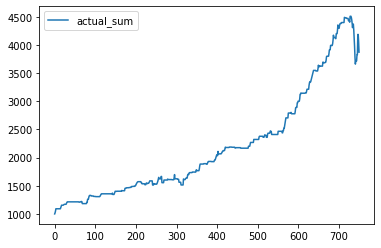

In [ ]:
sum_lst = runSimulation(True, False, 1000)
df_compare_acc['actual_sum'] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ['actual_sum'])

2564.4963065774746


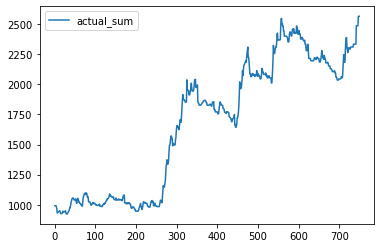

In [ ]:
sum_lst = runSimulation(False, True, 1000)
df_compare_acc['actual_sum'] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ['actual_sum'])

9925.554238582003


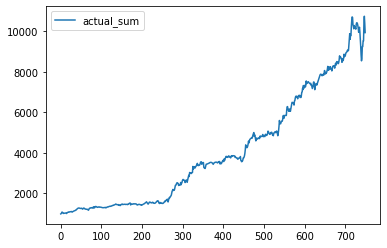

In [ ]:
sum_lst = runSimulation(True, True, 1000)
df_compare_acc['actual_sum'] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ['actual_sum'])